In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#NB run this code only if you want to collect dataset by yourselves!!!!!!!!!!!!
#use pickle instead                                                !!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

SIDE = 50
X = []
y = []
_dir = "D:/dataset/cats-dogs/train/"

for i in range(4000):
    cat = "cat.{}.jpg".format(i)
    dog = "dog.{}.jpg".format(i)
    catimg = cv2.imread(_dir + cat, cv2.IMREAD_COLOR)
    dogimg = cv2.imread(_dir + dog, cv2.IMREAD_COLOR)
    catimg = cv2.resize(catimg, (SIDE, SIDE), interpolation = cv2.INTER_CUBIC)
    dogimg = cv2.resize(dogimg, (SIDE, SIDE), interpolation = cv2.INTER_CUBIC)
    X.extend([catimg.flatten(), dogimg.flatten()])
    y.extend([0, 1])

import pickle

X = np.array(X)
y = np.array(y)

with open('X.pickle', 'wb') as f: pickle.dump(X, f)
with open('y.pickle', 'wb') as f: pickle.dump(y, f)

1


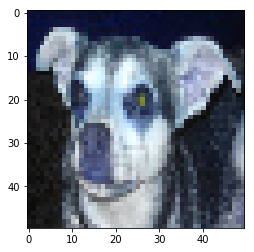

0


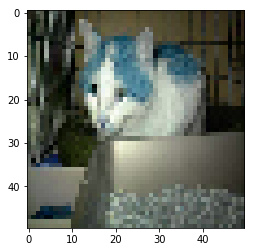

In [2]:
with open('X.pickle', 'rb') as f: X = pickle.load(f)
with open('y.pickle', 'rb') as f: y = pickle.load(f)

# test that data is ok
print(y[123])
plt.imshow(X[123].reshape((SIDE, SIDE, 3)))
plt.show()
print(y[124])
plt.imshow(X[124].reshape((SIDE, SIDE, 3)))
plt.show()

In [15]:
# be careful! It runs for ages

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(
    solver='lbfgs',    # https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm
                       # or sgd of adam
    alpha=1e-5,        # regularization term
    activation='relu', # rectifier linear unit
    hidden_layer_sizes=(2000, 100, 10),
                       # starts with the size of input, which is SIDE * SIDE * 3
    random_state=7,    # seed for random generator
    verbose=True
)
clf.fit(X, y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2000, 100, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=7, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [16]:
with open('ann.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [17]:
y1 = clf.predict(X)
print(np.dot((y1 - y), (y1 - y)))
from sklearn.metrics import classification_report
print(classification_report(y, y1))

2955
             precision    recall  f1-score   support

          0       0.63      0.65      0.64      4000
          1       0.64      0.61      0.62      4000

avg / total       0.63      0.63      0.63      8000



In [2]:
# based on https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
import keras
# cifar is 32x32 color images of 10 classes
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32       # number of samples before we update weights
num_classes = 10      # dataset class count
epochs = 10           # iterations for processing full dataset
data_augmentation = True
num_predictions = 20
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# let's stack some layers
model = Sequential()
# convolution means filter operation over image patch.
# padding - what we do on the edges of image
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
# rectifier linear units
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
# pooling - reducing image size my selecting maximum of 4 values
model.add(MaxPooling2D(pool_size=(2, 2)))

# set 1/4 of weights to 0 to avoid overfitting
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# each CNN is usially finished with fully-connected layer[s]
# put our tensors into vector
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# and the output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer. Of it can be sgd
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
model.save(model_name)
print('Saved trained model at %s ' % model_name)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/10
1563/1563 [==============================] - 306s 196ms/step - loss: 1.8699 - acc: 0.3101 - val_loss: 1.5931 - val_acc: 0.4125
Epoch 2/10
1563/1563 [==============================] - 291s 186ms/step - loss: 1.5773 - acc: 0.4238 - val_loss: 1.3977 - val_acc: 0.4891
Epoch 3/10
1563/1563 [==============================] - 289s 185ms/step - loss: 1.4560 - acc: 0.4736 - val_loss: 1.2982 - val_acc: 0.5254
Epoch 4/10
1563/1563 [==============================] - 290s 185ms/step - loss: 1.3678 - acc: 0.5107 - val_loss: 1.2333 - val_acc: 0.5510
Epoch 5/10
1563/1563 [==============================] - 291s 186ms/step - loss: 1.2946 - acc: 0.5382 - val_loss: 1.2032 - val_acc: 0.5689
Epoch 6/10
1563/1563 [==============================] - 292s 187ms/step - loss: 1.2499 - acc: 0.5543 - val_loss: 1.1057 - val_acc: 0.6033
Epoch 7/10
1563/1563 [==============================] - 291s 186